# Ajustando datos a un modelo con Bayes y Metropolis 

El teorema de bayes es de gran utilidad para el análisis de datos.
Típicamente este teorema se escribe de la siguiente manera:
    
$$
P({\rm modelo}|{\rm datos}) = \frac{P({\rm datos | modelo})P({\rm modelo})}{P({\rm datos})}.
$$

En esta ecuación $P({\rm datos| modelo})$ recibe el nombre de verosimilitud (likelihood), $P({\rm modelo})$ el de prior 
y $P({\rm datos})$ el de evidencia.

Típicamente un modelo toma la forma de un modelo parametrizado (por ejemplo, una recta con dos parámetros libres).
En este caso $P({\rm modelo}|{\rm datos})$ se puede reformular como la siguiente pregunta: ¿Cuál es la densidad de probabilidad de los parámetros de los modelos dadas las observaciones?

Si consideramos las observaciones como un conjunto $D_i$ de mediciones con incertidumbres $\sigma_i$ la verosimilitud puede tomar la siguiente forma de una distribución gaussiana centrada en la medición con desviación estándar igual a la incertidumbre:

$$
L \propto \prod_{i=0}^{M} \exp \left[ -\frac{1}{2} \left(\frac{D_i-D}{\sigma_i}\right)^2\right]
=\exp \left[ -\frac{1}{2} \sum_{i=0}^{M}\left(\frac{D_i-D}{\sigma_i}\right)^2\right] = \exp{\left(-\frac{1}{2}\chi^2\right)}
$$

donde hemos definido

$$
\chi^2 = \sum_{i=0}^{M}\left(\frac{D_i-D}{\sigma_i}\right)^2
$$

en este caso $D$ es el valor predicho para la medición dados los parámetros del modelo.

Para el caso del prior, $P({\rm datos})$, la elección más sencilla es una distribución uniforme sobre un rango de parámetros.

¿Qué hacer con la evidencia $P({\rm datos})$? Si la pensamos como una constante de normalización de la distribución de probabilidad que nos interesa $P({\rm modelo}|{\rm datos})$ en realidad no nos importa dado que será suficiente muestrear $P({\rm datos | modelo})P({\rm modelo})$ y luego encontrar la constante de normalización.

Lo mejor es concretar todo esto con un ejemplo. En este caso tenemos un conjunto de observaciones $x_i, y_i$ y un modelo correspondiente
a una recta $y=mx+b$. En este caso queremos conocer $P(m|{\rm datos})$ y $P(b|{\rm datos})$.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<ErrorbarContainer object of 3 artists>

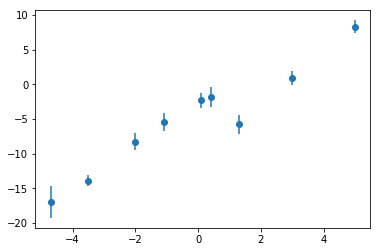

In [2]:
x_obs = np.array([-2.0,1.3,0.4,5.0,0.1, -4.7, 3.0, -3.5,-1.1])
y_obs = np.array([ -8.3,   -5.77,  -1.86, 8.3, -2.35, -16.98,  0.934, -13.89,  -5.49 ])
sigma_y_obs = np.array([-1.2,-1.36, -1.44, 0.92,-1.02, 2.3,-1.0, 0.8, -1.3])

plt.errorbar(x_obs,y_obs, yerr=sigma_y_obs, fmt='o')

Para usar Bayes planteamos la siguiente verosimilitud
$$
\mathcal{L}({x_i, y_i, \sigma_i}|m, b) = \prod_{i=1}^{N}\exp\left[-\frac{1}{2}\left(\frac{y_i - y_{model}(x_i, m, b)}{\sigma_i}\right)^2\right]
$$

In [3]:
def model(x,m,b):
    return x*m + b

# Numericamente es mas estable trabajar con el logaritmo
def loglikelihood(x_obs, y_obs, sigma_y_obs, m, b):
    d = y_obs -  model(x_obs, m, b)
    d = d/sigma_y_obs
    d = -0.5 * np.sum(d**2)
    return d

# Numericamente es mas estable trabajar con el logaritmo
def logprior(m, b):
    p = -np.inf
    if m < 10 and m >-10 and b >-20 and b<20:
        p = 0.0
    return p


Y ahora simplemente aplicamos el algoritmo de Metropolis-Hastings.

In [4]:
N = 50000
lista_m = [np.random.random()]
lista_b = [np.random.random()]
logposterior = [loglikelihood(x_obs, y_obs, sigma_y_obs, lista_m[0], lista_b[0]) + logprior(lista_m[0], lista_b[0])]

sigma_delta_m = 0.2
sigma_delta_b = 1.0

for i in range(1,N):
    propuesta_m  = lista_m[i-1] + np.random.normal(loc=0.0, scale=sigma_delta_m)
    propuesta_b  = lista_b[i-1] + np.random.normal(loc=0.0, scale=sigma_delta_b)

    logposterior_viejo = loglikelihood(x_obs, y_obs, sigma_y_obs, lista_m[i-1], lista_b[i-1]) + logprior(lista_m[i-1], lista_b[i-1])
    logposterior_nuevo = loglikelihood(x_obs, y_obs, sigma_y_obs, propuesta_m, propuesta_b) + logprior(propuesta_m, propuesta_b)

    r = min(1,np.exp(logposterior_nuevo-logposterior_viejo))
    alpha = np.random.random()
    if(alpha<r):
        lista_m.append(propuesta_m)
        lista_b.append(propuesta_b)
        logposterior.append(logposterior_nuevo)
    else:
        lista_m.append(lista_m[i-1])
        lista_b.append(lista_b[i-1])
        logposterior.append(logposterior_viejo)
lista_m = np.array(lista_m)
lista_b = np.array(lista_b)
logposterior = np.array(logposterior)

Este histograma representa $P(b|{\rm datos})$

Text(0,0.5,'P(b|datos)')

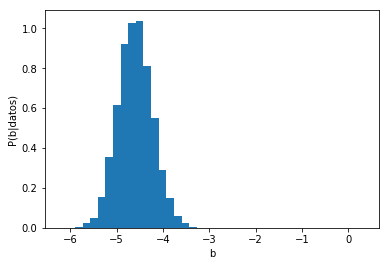

In [5]:
_=plt.hist(lista_b, bins=40, density=True)
plt.xlabel('b')
plt.ylabel('P(b|datos)')

Este histograma representa $P(m|{\rm datos})$

Text(0,0.5,'P(m|datos)')

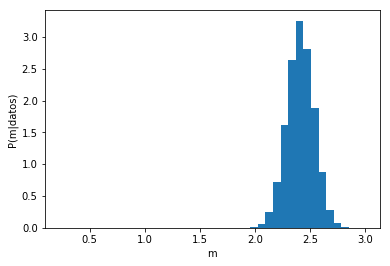

In [6]:
_=plt.hist(lista_m, bins=40, density=True)
plt.xlabel('m')
plt.ylabel('P(m|datos)')

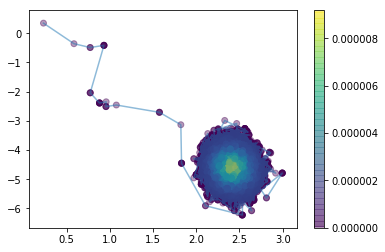

In [7]:

plt.plot(lista_m, lista_b, alpha=0.5)
plt.scatter(lista_m, lista_b, alpha=0.4, c=np.exp(logposterior))
plt.colorbar()

Este histograma representa $P(m, b|{\rm datos})$

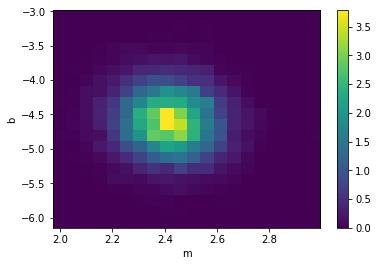

In [8]:
_=plt.hist2d(lista_m[100:], lista_b[100:], bins=20, normed=True)
plt.xlabel('m')
plt.ylabel('b')
plt.colorbar()

Y así se ven las cadenas de Markov

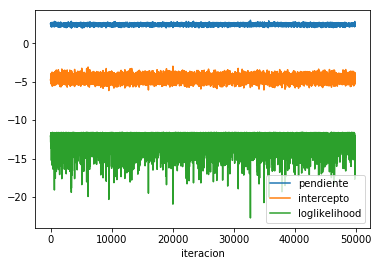

In [9]:
plt.plot(lista_m[100:], label='pendiente')
plt.plot(lista_b[100:], label='intercepto')
plt.plot(logposterior[100:], label='loglikelihood')
plt.xlabel('iteracion')
plt.legend()

Finalmente, si graficamos la recta correspondiente a los valores medios de las distribuciones $P(m|{\rm datos})$ y $P(b|{\rm datos})$:

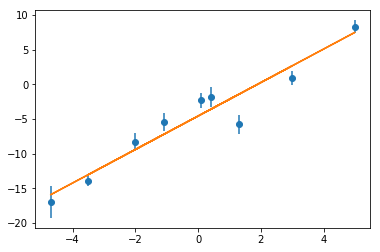

In [10]:
y_model = model(x_obs,np.mean(lista_m),np.mean(lista_b))
plt.errorbar(x_obs,y_obs, yerr=sigma_y_obs, fmt='o')
plt.plot(x_obs, y_model)

# Ejercicio 8.1

Ajuste la siguiente serie de datos a  un modelo cuadrático utilizando el Teorema de Bayes y el algoritmo de Metropolis-Hastings.

<ErrorbarContainer object of 3 artists>

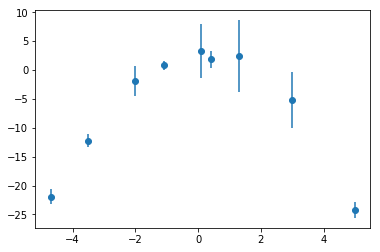

In [11]:
x = np.array([-2.0,1.3,0.4,5.0,0.1, -4.7, 3.0, -3.5,-1.1])
z = np.array([ -1.931,   2.38,   1.88,  -24.22,   3.31, -21.9,  -5.18, -12.23,   0.822])
sigma_z = ([ 2.63,  6.23, -1.461, 1.376, -4.72,  1.313, -4.886, -1.091,  0.8054])
plt.errorbar(x, z, yerr=sigma_z, fmt='o')